<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/CN/W1D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Dimensionality Reduction & Reconstruction

**Week 1, Day 4: Dimensionality Reduction**

**By Neuromatch Academy**

__Content creators:__ Alex Cayco Gajic, John Murray

__Content reviewers:__ Roozbeh Farhoudi, Matt Krause, Spiros Chavlis, Richard Gao, Michael Waskom,  Siddharth Suresh, Natalie Schaworonkow, Ella Batty

---
# Setup

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Figure Settings
import ipywidgets as widgets   # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_MNIST_reconstruction(X, X_reconstructed):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable

  Returns:
    Nothing.
  """

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title('Reconstructed')
  plt.tight_layout()


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """

  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

In [ ]:
# @title Helper Functions

def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals

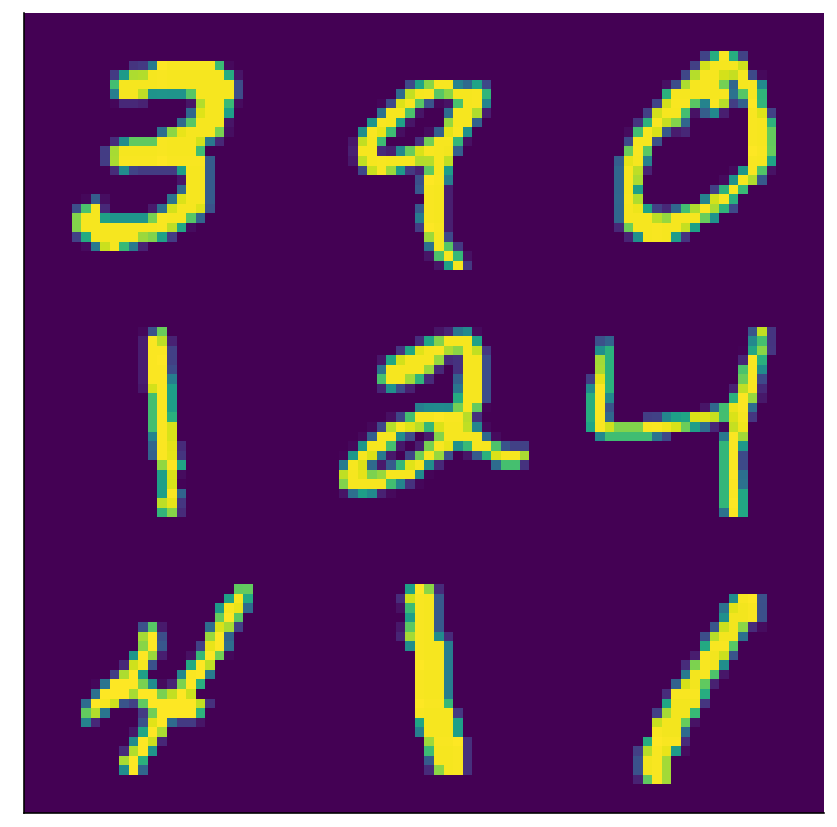

In [ ]:
from sklearn.datasets import fetch_openml

# GET mnist data
mnist = fetch_openml(name='mnist_784', as_frame = False)
X = mnist.data

# Visualize
plot_MNIST_sample(X)

In [ ]:
help(pca)

(0.0, 100.0)

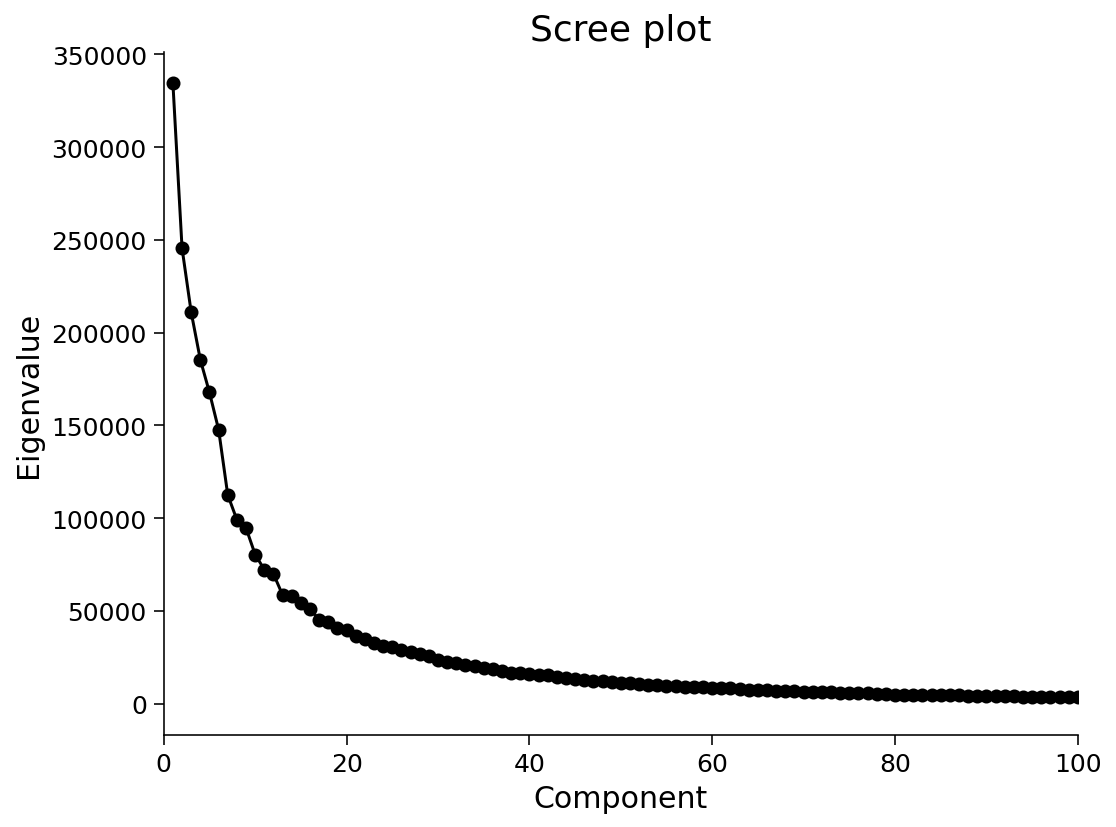

In [ ]:
# Perform PCA
score, evectors, evals = pca(X)

# Plot the eigenvalues
plot_eigenvalues(evals, limit=False)
plt.xlim([0,100])  # limit x-axis up to 100 for zooming

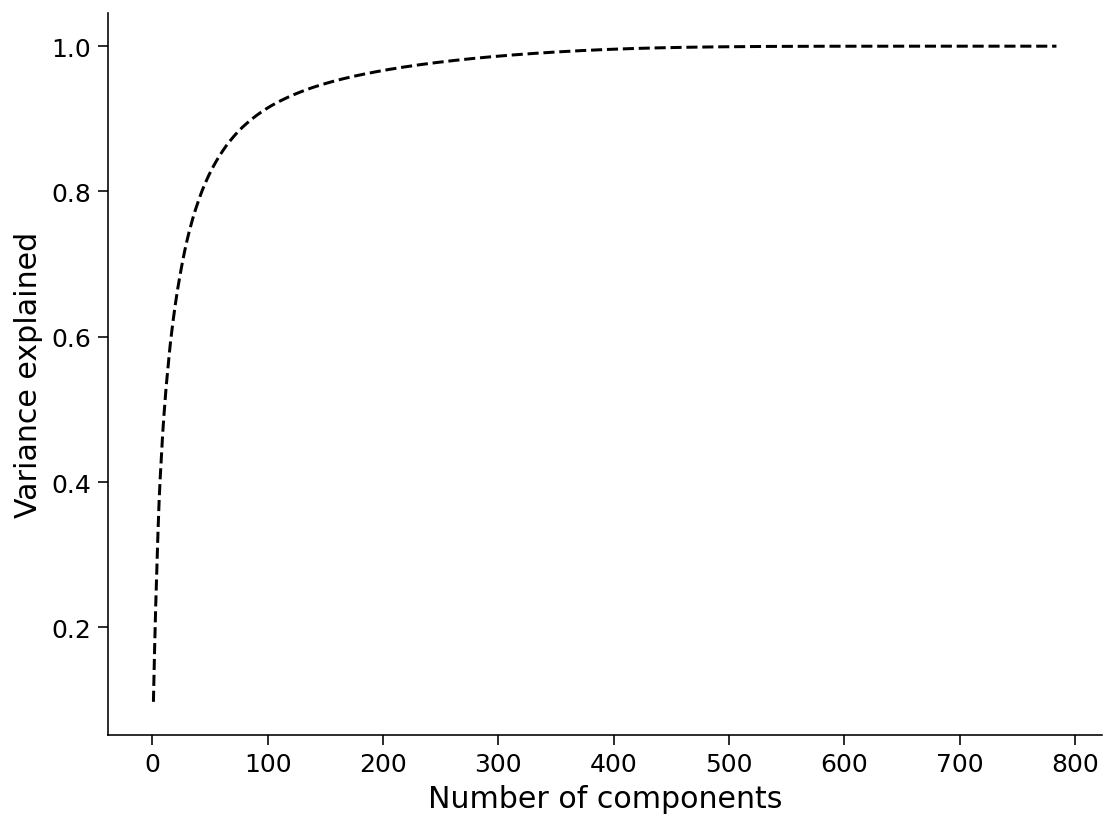

In [ ]:
def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.

  Args:
    evals (numpy array of floats) : Vector of eigenvalues

  Returns:
    (numpy array of floats)       : Vector of variance explained

  """
  # Cumulatively sum the eigenvalues
  csum = np.cumsum(evals)

  # Normalize by the sum of eigenvalues
  variance_explained = csum/np.sum(evals)

  return variance_explained


# Calculate the variance explained
variance_explained = get_variance_explained(evals)

# Visualize
plot_variance_explained(variance_explained)

---
# Section 3: Reconstruct data with different numbers of PCs

*Estimated timing to here from start of tutorial: 25 min*



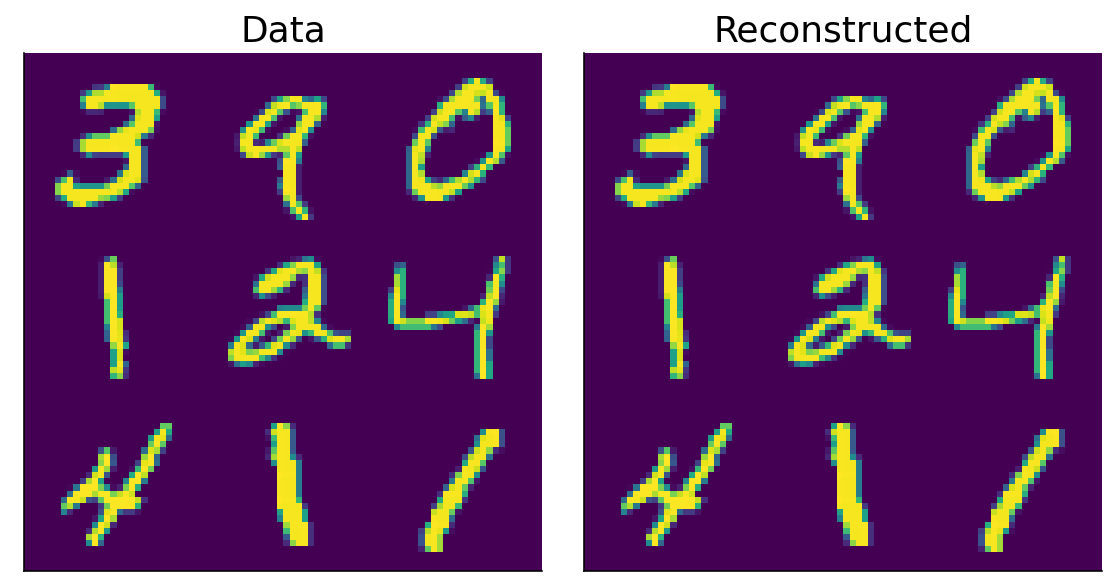

In [ ]:
def reconstruct_data(score, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.

  Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include

  Returns:
    (numpy array of floats)          : Matrix of reconstructed data

  """
  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!
  X_reconstructed =  np.matmul(score[:, :K], evectors[:, :K].T) + X_mean

  return X_reconstructed


K = 784

# Reconstruct the data based on all components
X_mean = np.mean(X, 0)
X_reconstructed = reconstruct_data(score, evectors, X_mean, K)

# Plot the data and reconstruction
plot_MNIST_reconstruction(X, X_reconstructed)

In [ ]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def refresh(K=100):
  X_reconstructed = reconstruct_data(score, evectors, X_mean, K)
  plot_MNIST_reconstruction(X, X_reconstructed)
  plt.title('Reconstructed, K={}'.format(K))


_ = widgets.interact(refresh, K=(1, 784, 10))

interactive(children=(IntSlider(value=100, description='K', max=784, min=1, step=10), Output()), _dom_classes=…

---
# Section 4: Visualize PCA components

*Estimated timing to here from start of tutorial: 40 min*

In [ ]:
help(plot_MNIST_weights)

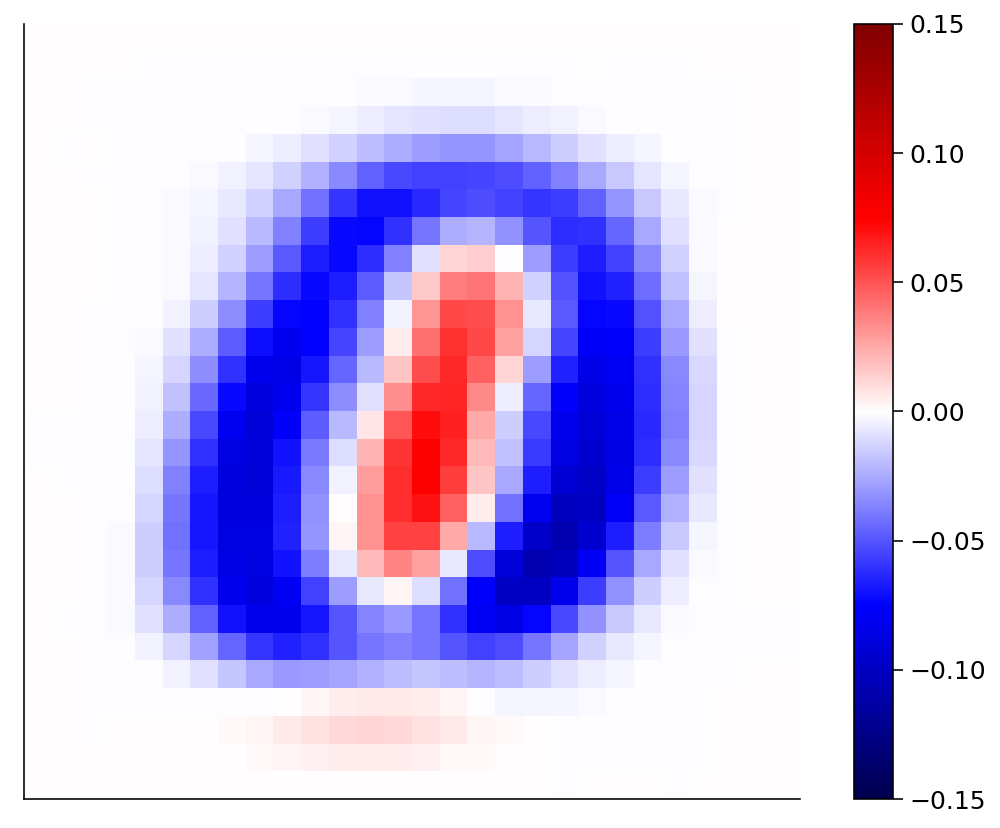

In [ ]:
# Plot the weights of the first principal component
plot_MNIST_weights(evectors[:,0])

---
# Bonus

---
## Bonus Section 1: Examine denoising using PCA

In [ ]:
help(add_noise)

Help on function add_noise in module __main__:

add_noise(X, frac_noisy_pixels)
    Randomly corrupts a fraction of the pixels by setting them to random values.
    
    Args:
       X (numpy array of floats)  : Data matrix
       frac_noisy_pixels (scalar) : Fraction of noisy pixels
    
    Returns:
       (numpy array of floats)    : Data matrix + noise



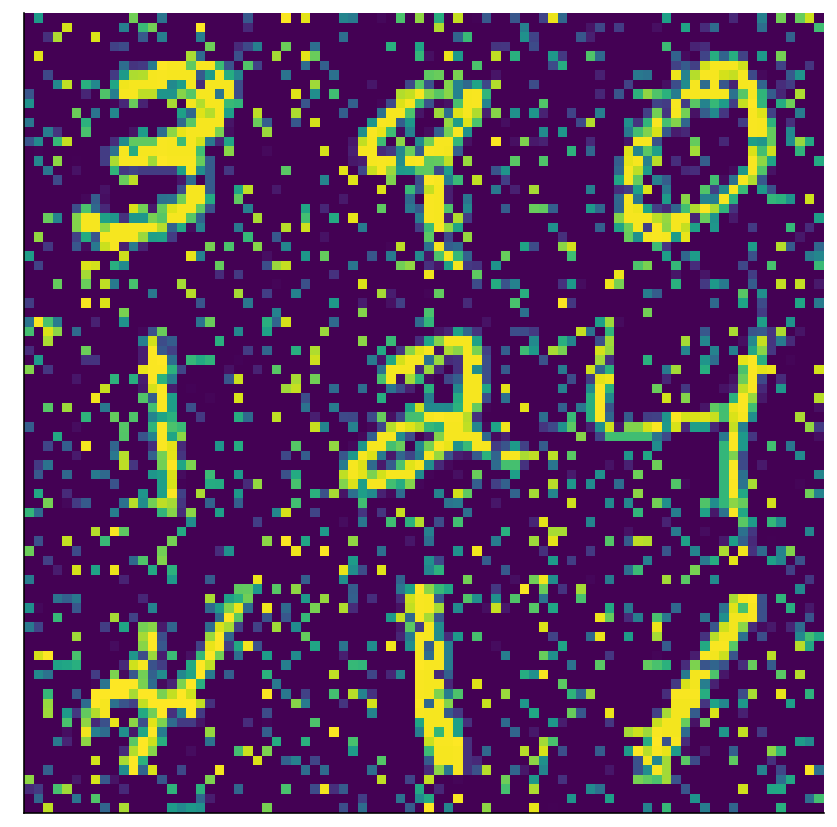

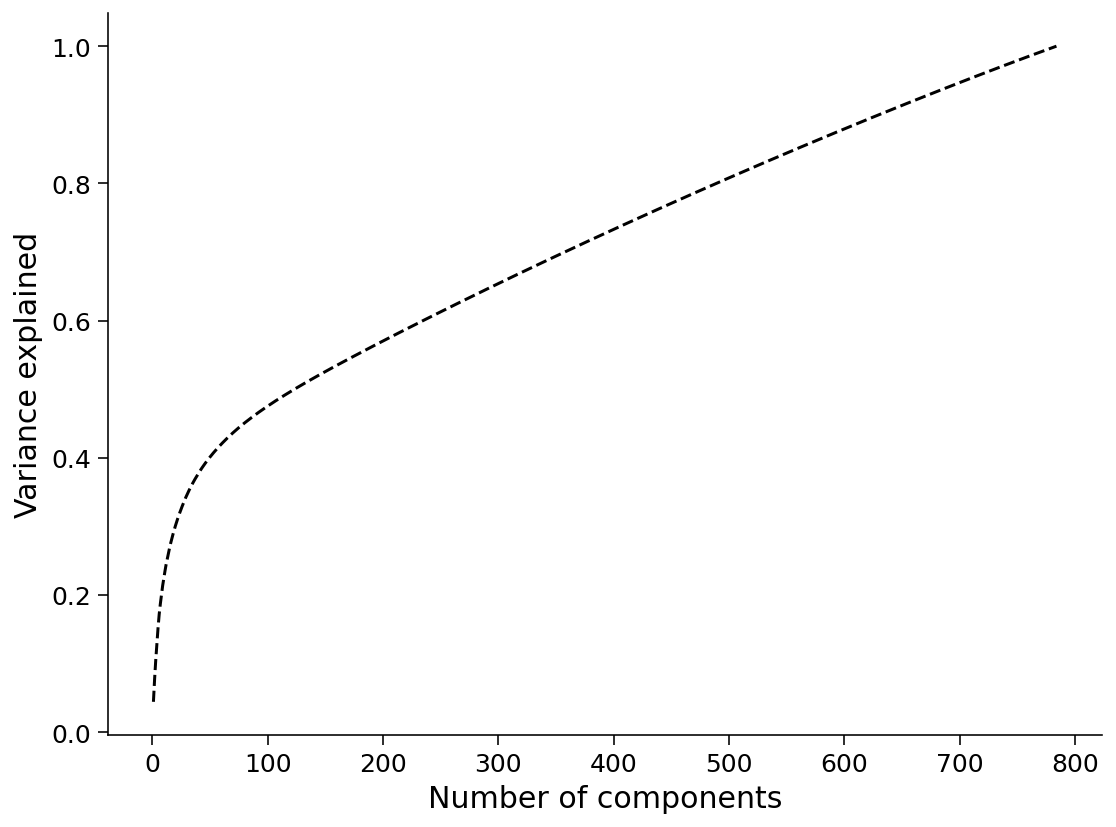

In [ ]:
np.random.seed(2020)  # set random seed

# Add noise to data
X_noisy = add_noise(X,1/5)

# Perform PCA on noisy data
score_noisy, evectors_noisy, evals_noisy = pca(X_noisy)

# Compute variance explained
variance_explained_noisy = get_variance_explained(evals_noisy)

# Visualize
plot_MNIST_sample(X_noisy)
plot_variance_explained(variance_explained_noisy)

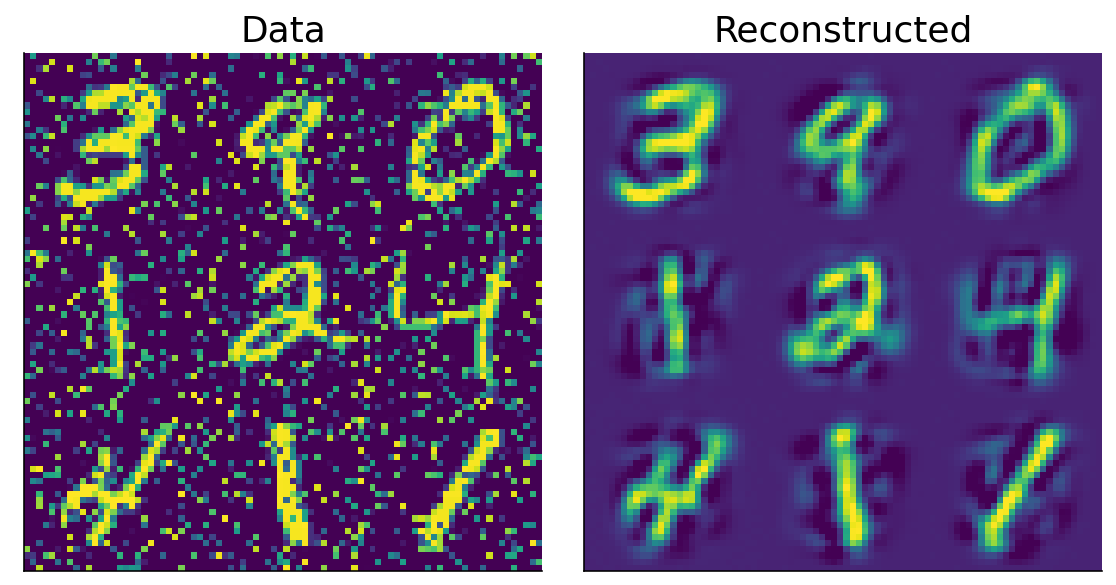

In [ ]:
np.random.seed(2020)  # set random seed

# Add noise to data
X_noisy = add_noise(X,1/5)

# Compute mean of noise-corrupted data
X_noisy_mean = np.mean(X_noisy, 0)

# Project onto the original basis vectors
projX_noisy = np.matmul(X_noisy - X_noisy_mean, evectors)

k= 700
# Reconstruct the data using the top 50 components
X_reconstructed = reconstruct_data(projX_noisy, evectors, X_noisy_mean, 50)

# Visualize
plot_MNIST_reconstruction(X_noisy, X_reconstructed)